In [1]:
%load_ext autoreload
%autoreload 2

from vflow import Vset, build_vset, init_args, dict_to_df, perturbation_stats
from vflow.pipeline import build_graph

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.impute import KNNImputer, SimpleImputer

import numpy as np
import pandas as pd

import ray

pd.options.display.max_rows = 8
np.random.seed(31415)

# Feature Importance Stability

In this example, we will probe the the stability of the permutation feature importance metric for random forest relative to data resampling, data preprocessing, and model hyperparameter perturbations.

`vflow` supports automatic parallelization using `ray`. We can use `ray` to compute downstream results by setting `is_async=True` when constructing a `Vset`:

In [2]:
ray.init(num_cpus=4)

2021-12-13 21:25:00,204	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.83',
 'raylet_ip_address': '192.168.1.83',
 'redis_address': '192.168.1.83:6379',
 'object_store_address': '/tmp/ray/session_2021-12-13_21-24-57_791745_81067/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-13_21-24-57_791745_81067/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-12-13_21-24-57_791745_81067',
 'metrics_export_port': 54449,
 'node_id': '40cd6feacbbf61231c9c4366df088c705c5cd6178cf24ea32f876554'}

### Define stability target

Below, we create a `Vset` which applies three custom data preprocessing functions and another that calculates the permutation importance metric via the function `sklearn.inspection.permutation_importance`.

In [4]:
from vflow import Vset
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance

preproc_list = [SimpleImputer(strategy='mean'),
                SimpleImputer(strategy='median'),
                KNNImputer()]

# create a Vset which varies over the list of preprocessing methods
preproc_set = Vset("preproc", preproc_list, ['mean', 'med', 'knn'], output_matching=True, lazy=True)

# create the feature importance Vset
feat_imp_set = build_vset('feat_imp', permutation_importance, n_repeats=3, is_async=True)

### Define model hyperparameter perturbations

We can also specify modeling perturbations, both within a single class of models (hyperparameter perturbations) and across different classes. Here we'll use the helper `build_vset` to create hyperparameter perturbations for random forest.

In [5]:
from sklearn.ensemble import RandomForestRegressor as RF
from vflow import build_vset

# hyperparameters to try
RF_params = {
    'n_estimators': [100, 300],
    'min_samples_split': [2, 10]
}

# we could instead pass a list of distinct models and corresponding param dicts
RF_set = build_vset('RF', RF, RF_params, is_async=True)

### Define data perturbations

For stability analysis, it is often useful to add data perturbations such as the bootstrap in order to assess stability over resampling variability in the data. We can lazily compute the bootstrap, such that data will not be resampled until needed, by setting `lazy=True` when constructing a `Vset`:

In [6]:
from sklearn.utils import resample

# create a Vset for bootstrapping from data 10 times
# we use lazy=True so that the data will not be resampled until needed
boot_set = build_vset('boot', resample, reps=10, lazy=True)

### Fit all models for all combinations of resampling and preprocessing

Now we can load in our data and fit each of the four random forest models to the 300 combinations of resampled training data and preprocessing functions.

In [ ]:
X, y = make_regression(n_samples=1000, n_features=3, n_informative=1)

# 20% of X entries missing
i = np.random.randint(X.shape[0], size=round(X.shape[0]*X.shape[1] * 0.2))
j = np.random.randint(X.shape[1], size=i.size)
X[i, j] = np.nan

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval)

X_train, y_train = init_args([X_train, y_train], names=['X_train', 'y_train'])
X_val, y_val = init_args([X_val, y_val], names=['X_val', 'y_val'])

In [7]:
# bootstrap from training data by calling boot_fun
X_trains, y_trains = boot_set(X_train, y_train)

# apply three preprocessing methods to each bootstrap sample
X_trains = preproc_set.fit_transform(X_trains)

In [8]:
%%time

# this results in fitting all 4 RF models to each of the 30 boot/preproc combos
RF_set.fit(X_trains, y_trains)

CPU times: user 1.5 s, sys: 389 ms, total: 1.89 s
Wall time: 14.4 s


We can examine the pipeline graph to see what happened so far using the utility function `build_graph`:

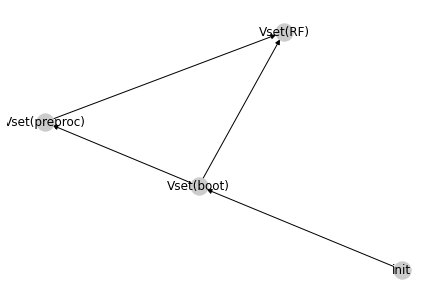

In [9]:
from vflow import build_graph

# examine the pipeline graph
build_graph(RF_set)

### Calculate feature importances and perturbation statistics

Finally, we calculate the importance metric and examine its mean and standard deviation across bootstrap perturbations for each combination of data preprocessing and modeling hyperparameters. This allows us to assess the stability of the feature importances conditioned on different pipeline paths:

In [10]:
%%time

from vflow import dict_to_df, perturbation_stats

# calculate importances
importances = feat_imp_set.evaluate(RF_set.out, preproc_set.fit_transform(X_val), y_val)

CPU times: user 2.15 s, sys: 230 ms, total: 2.38 s
Wall time: 7.53 s


Multiple outputs can be split with `dict_to_df` using `param_key='out'`. We use it below to split feature importances into mean and std:

In [11]:
# the helper dict_to_df converts the output to a pandas.DataFrame
# using param_key='out' separates the importance dict into multiple cols
importances_df = dict_to_df(importances, param_key='out')
importances_df

,init-boot,boot,init-preproc,preproc,init-RF,RF,init-feat_imp,init-feat_imp,init-feat_imp,feat_imp,out,out-importances_mean,out-importances_std,out-importances
0,X_train,"(rep=0,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [0.008761979340984624, -0...","[0.008761979340984624, -0.03558942692257405, 1...","[0.01326207049286781, 0.0034690864117961607, 0...","[[0.02275840447105626, -0.009048209607692481, ..."
1,X_train,"(rep=1,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.010073280418657293, 0...","[-0.010073280418657293, 0.012168807698989018, ...","[0.0033459757009757043, 0.007542337590601749, ...","[[-0.008080725092555752, -0.007352620828861567..."
2,X_train,"(rep=2,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.011914204294315075, 0...","[-0.011914204294315075, 0.009041604244378535, ...","[0.01564443940914106, 0.015410467344513413, 0....","[[-0.012603328568590255, -0.03072079244744419,..."
3,X_train,"(rep=3,)",X_train,mean,y_train,"(n_estimators=100, min_samples_split=2)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [-0.005313319867751372, 0...","[-0.005313319867751372, 0.009082512805862586, ...","[0.008018689652769454, 0.013622028130875485, 0...","[[-0.0032052164087308377, 0.003282291633944778..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,X_train,"(rep=6,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [0.0016734301804808653, 0...","[0.0016734301804808653, 0.002656624691471617, ...","[0.013277010734487383, 0.008198287925124313, 0...","[[0.0028691181886598693, 0.017303533326473608,..."
117,X_train,"(rep=7,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [0.024444981879042354, -0...","[0.024444981879042354, -0.0006362401761585978,...","[0.010987395218453665, 0.003433490221814577, 0...","[[0.03998322887113548, 0.016595603543394954, 0..."
118,X_train,"(rep=8,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [0.005365284912533112, -0...","[0.005365284912533112, -0.0565728363177049, 1....","[0.0010804277343730412, 0.021227197736827744, ...","[[0.003913305163604774, 0.005679204113046565, ..."
119,X_train,"(rep=9,)",X_train,knn,y_train,"(n_estimators=300, min_samples_split=10)",X_val,X_val,y_val,feat_imp_0,"{'importances_mean': [0.01248406187288457, -0....","[0.01248406187288457, -0.010193188995873848, 1...","[0.008427270679040564, 0.007342116321500198, 0...","[[0.01947683290253177, 0.000629793752883967, 0..."


We can compute statistics on a single iterable item of the output by passing `wrt=out-col` and `split=True`:

In [12]:
# get count, mean, and std of importances
perturbation_stats(importances_df, 'preproc', 'RF', wrt='out-importances_mean', prefix='X', split=True)

,preproc,RF,X-count,X0-mean,X0-std,X1-mean,X1-std,X2-mean,X2-std
0,knn,"(n_estimators=100, min_samples_split=10)",10,0.002658,0.007482,-0.019426,0.020168,1.345494,0.080863
1,knn,"(n_estimators=100, min_samples_split=2)",10,0.012256,0.015797,-0.022497,0.028343,1.371031,0.080874
2,knn,"(n_estimators=300, min_samples_split=10)",10,0.007747,0.010101,-0.015113,0.025376,1.428892,0.069200
3,knn,"(n_estimators=300, min_samples_split=2)",10,0.006885,0.010774,-0.021748,0.028230,1.385072,0.126618
...,...,...,...,...,...,...,...,...,...
8,med,"(n_estimators=100, min_samples_split=10)",10,-0.007374,0.010194,-0.004911,0.015810,1.482730,0.063334
9,med,"(n_estimators=100, min_samples_split=2)",10,0.008385,0.015032,-0.007913,0.021449,1.503880,0.068309
10,med,"(n_estimators=300, min_samples_split=10)",10,-0.001915,0.013333,-0.008601,0.020682,1.465643,0.046286
11,med,"(n_estimators=300, min_samples_split=2)",10,0.005687,0.010353,0.002442,0.024509,1.496973,0.092036


From here, we can (optionally) filter over the data preprocessing and modeling perturbations via the helper `filter_vset_by_metric` to select the top combinations in terms of stability (or another metric of interest) and continue our analysis on a held-out test set.

In [13]:
ray.shutdown()